# OBJECTIVE  
### 시계열의 안정성이 충분히 확인되었는가?
플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며,  
이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음  
### ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?  
p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨  
### 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨  

In [4]:
import pandas
import sklearn
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')


In [5]:
#삼성주식으로 재현

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head(10)

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
2020-05-25    48850.0
2020-05-26    49250.0
2020-05-27    49900.0
2020-05-28    50400.0
2020-05-29    50700.0
Name: Close, dtype: float64

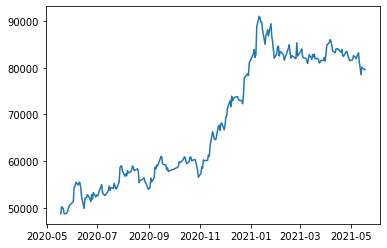

In [6]:
plt.plot(ts)

원본 데이터의 시계열 추이를 확인합니다  

### 전처리  
결측치 처리  
로그 변환  

In [7]:
#결측치가 있으면 interpolate

ts = ts.interpolate(method='time')
ts[ts.isna()]


Series([], Name: Close, dtype: float64)

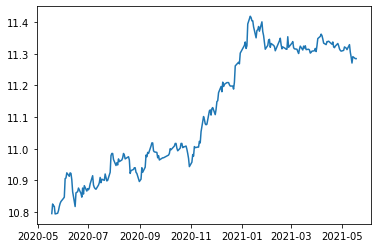

In [8]:
#로그변환

ts_log = np.log(ts)
plt.plot(ts_log)


로그변환 데이터의 y축 값 범위가 축소됨을 확인

### 시계열 안정성 분석  
정성적 그래프 분석  
정량적 Augmented Dicky-Fuller Test  
시계열 분해  
Residual 안정성 확인  

#### 그래프 시각화를 위한 함수

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#### 정성적 그래프 분석  

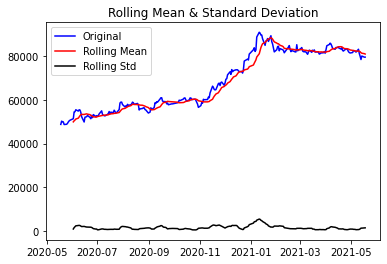

In [10]:
plot_rolling_statistics(ts, window=12)


원본 데이터의 mean, std를 확인했습니다  
log 변환된 데이터를 쓰게 되겠지만, 궁금했습니다  
rolling mean은 데이터의 범위를 거의 벗어나지 않고  
rolling std에도 엄청나게 큰 증가는 없습니다  

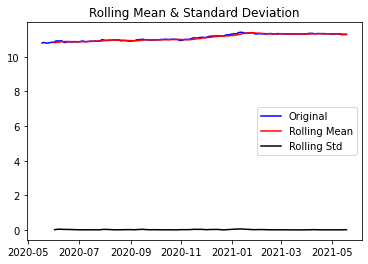

In [11]:
plot_rolling_statistics(ts_log, window=12)


log 변환 데이터의 mean, std를 확인했습니다  
rolling mean은 original과 거의 겹침,  
rolling std는 거의 평탄합니다  

#### 시계열의 Augmented Dicky-Fuller Test를 위한 함수   

#### 정량적 ADF

In [12]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    #0에 가까우면 귀무가설을 기각, 대립가설인 안정적인 시계열이라는 것을 채택
    

In [13]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)


Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


P-value가 0.5, 귀무가설을 기각하기 위해 시계열 데이터를 가공합니다

#### 시계열 분해    
추세(Trend) 와 계절성(Seasonality) 추출

In [14]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


#### Residual 안정성 확인  
원본데이터, Trend, Seasonality, Residual 확인  

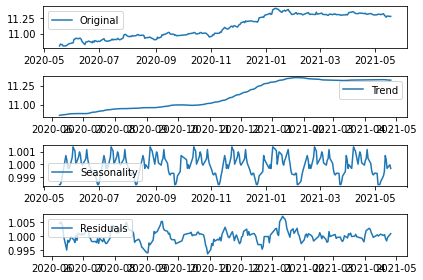

In [15]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

그래프 확인결과, Residual의 값 오차범위는 0.01정도, 하지만 균일하지는 않습니다  
정량적으로 Residual 안정성을 확인해보겠습니다  

In [16]:

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


P-value가 엄청나게 작습니다  
이 시계열 데이터로 ARIMA 모델을 만들 수 있을것이라 생각하므로, 모델 생성을 위한 준비를 시작합니다  

#### ARIMA 모수 탐색  
p : 자기회귀 모형(AR)의 시차  
d : 차분 누적(I) 횟수  
q : 이동평균 모형(MA)의 시차  

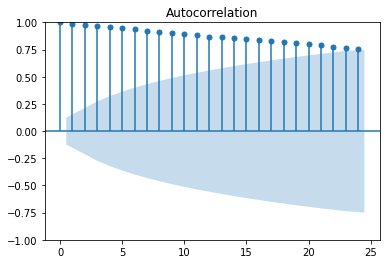

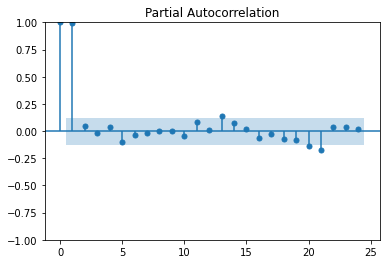

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF에서 AR(p)는 점차적으로 감소, MA(q)는 시차 q 이후에 0  
PACF에서 AR(p)는 시차p 이후에 0, MA(q)는 점차적으로 감소

p = 1  
q = 적합한 값이 없어보이지만, MA를 고려할 필요가 없다면 

일반적으로 p + q < 2, p * q = 0 인 점을 고려하여

q = 0 으로 선정합니다

d는 차분을 구해보고, 시계열의 안정상태를 확인해본 후 판단합니다

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


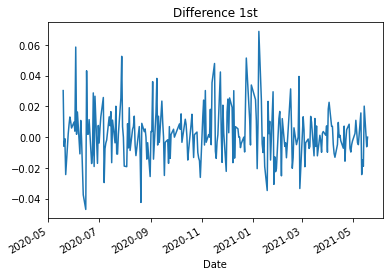

In [18]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


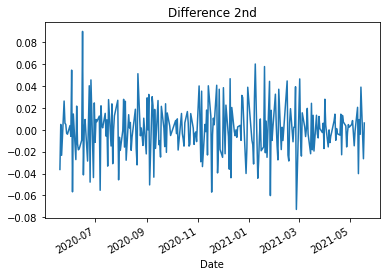

In [19]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 차분이 안정적으로 보입니다  
2차 차분으로 진행해보도록 합니다

p, d, q = 1, 2, 0  

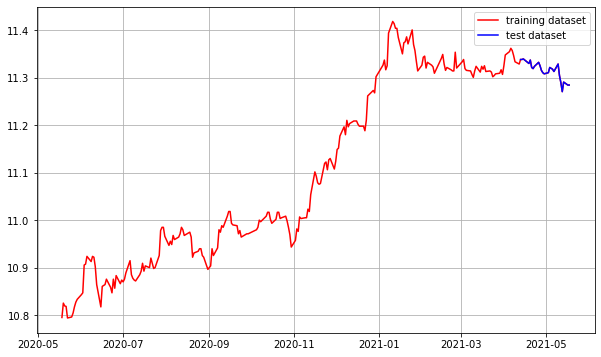

In [20]:
#학습 데이터 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [21]:
#데이터셋 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


#### ARIMA 모델을 학습시킨 후, 학습 결과를 확인  

In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 535.969
Date:                Mon, 21 Nov 2022   AIC                          -1067.938
Time:                        15:46:09   BIC                          -1061.124
Sample:                             0   HQIC                         -1065.187
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4734      0.058     -8.155      0.000      -0.587      -0.360
sigma2         0.0005   3.78e-05     12.655      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   4.73   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


#### 테스트 데이터를 예측, 실제값과 비교해봅니다   

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


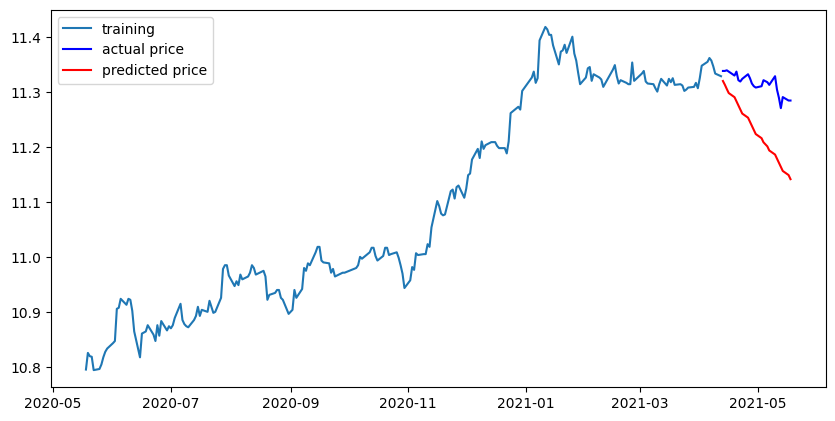

In [23]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

예측값 그래프가 실제값과 상당히 동떨어져서 나왔습니다  
에러를 확인해봅니다  

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  51283518.26120751
MAE:  6577.605102184043
RMSE:  7161.25116590722
MAPE: 8.06%


8.06%이면 루브릭의 달성조건이긴 하지만, 아래 비교할 lms상의 prediction이랑은 상당히 뒤쳐집니다  
p, d, q의 값을 잘 선정하기 위해 더 나은 분석을 해야할 것 같습니다

In [25]:

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Mon, 21 Nov 2022   AIC                          -1156.722
Time:                        15:46:10   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


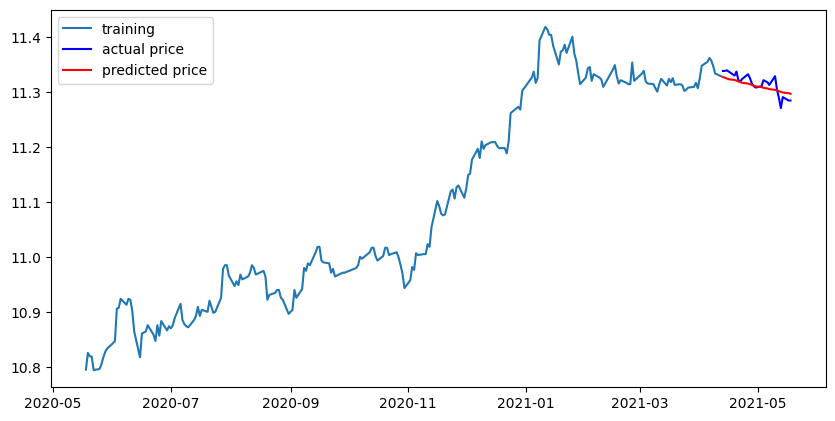

In [26]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


# 여기서부터 새로운 데이터셋을 사용하겠습니다  

세계의 연인 테슬라 데이터셋 정보 https://finance.yahoo.com/quote/TSLA/history?p=TSLA  
한국의 연인 카카오 데이터셋 정보 https://finance.yahoo.com/quote/035720.KS/history?p=035720.KS  
어머니 ㅠㅠ 많이 물리셨네요 ㅠㅠㅠ 퀀텀스케이프 데이터셋 정보 https://finance.yahoo.com/quote/QS/history?p=QS  

In [28]:
#데이터 불러오기

dataset_filepath_tsla = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
dataset_filepath_kakao = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
dataset_filepath_QS = os.getenv('HOME') + '/aiffel/stock_prediction/data/QS.csv'

df_tsla = pd.read_csv(dataset_filepath_tsla, index_col='Date', parse_dates=True)
df_kakao = pd.read_csv(dataset_filepath_kakao, index_col='Date', parse_dates=True)
df_QS = pd.read_csv(dataset_filepath_QS, index_col='Date', parse_dates=True)

ts_tsla = df_tsla['Close']
ts_kakao = df_kakao['Close']
ts_QS = df_QS['Close']


In [29]:
#각 데이터 정보확인
ts_tsla.head(10)

Date
2021-11-22    385.623322
2021-11-23    369.676666
2021-11-24    372.000000
2021-11-26    360.640015
2021-11-29    378.996674
2021-11-30    381.586670
2021-12-01    365.000000
2021-12-02    361.533325
2021-12-03    338.323334
2021-12-06    336.336670
Name: Close, dtype: float64

In [30]:
ts_kakao.head(10)

Date
2021-11-22    129444.945313
2021-11-23    125415.531250
2021-11-24    125415.531250
2021-11-25    128941.273438
2021-11-26    126422.890625
2021-11-29    123904.500000
2021-11-30    122897.148438
2021-12-01    123400.828125
2021-12-02    123400.828125
2021-12-03    124408.179688
Name: Close, dtype: float64

In [31]:
#하....
ts_QS.head(10)

Date
2021-11-22    33.619999
2021-11-23    32.369999
2021-11-24    32.200001
2021-11-26    30.639999
2021-11-29    30.320000
2021-11-30    28.840000
2021-12-01    27.309999
2021-12-02    27.350000
2021-12-03    24.549999
2021-12-06    24.820000
Name: Close, dtype: float64

In [32]:
ts_QS.tail(10)

Date
2022-11-07    7.81
2022-11-08    7.93
2022-11-09    6.74
2022-11-10    7.23
2022-11-11    7.51
2022-11-14    7.61
2022-11-15    8.11
2022-11-16    7.42
2022-11-17    7.15
2022-11-18    7.22
Name: Close, dtype: float64

ㅎ ㅏ...........................

## 전처리 - 결측치 제거 및 로그 변환

In [33]:
ts_tsla = ts_tsla.interpolate(method='time')
ts_kakao = ts_kakao.interpolate(method='time')
ts_QS = ts_QS.interpolate(method='time')

ts_tsla[ts_tsla.isna()]

Series([], Name: Close, dtype: float64)

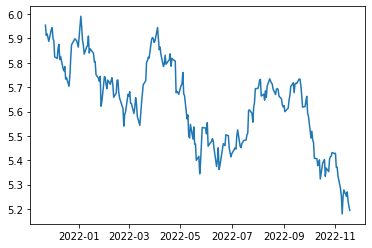

In [34]:
#다른 데이터들도 Nan이 없는 것을 확인

ts_tsla_log = np.log(ts_tsla)
plt.plot(ts_tsla_log)

세계의 연인 테슬라의 주가는 2달 주기로 큰 상승과 낙폭을 보이며 감소하고 있습니다

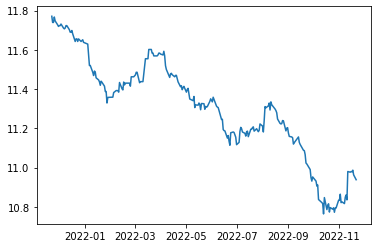

In [35]:
ts_kakao_log = np.log(ts_kakao)
plt.plot(ts_kakao_log)

한국의 인기종목 카카오 또한 테슬라와 비슷한 양상을 보이고 있습니다

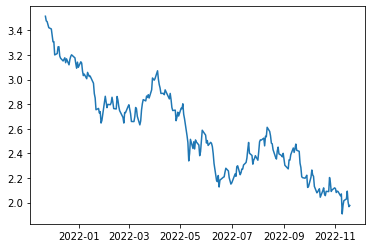

In [36]:
#무섭습니다

ts_QS_log = np.log(ts_QS)
plt.plot(ts_QS_log)

등락폭과 가격폭..이 많이 다르지만 세 주식이 상당히 비슷한 양상을 보이고 있습니다 '하락세'  

## 시계열 안정성 분석  
#### 정성적 그래프 분석
반영주기를 일주일 단위, 5일로 분석해보겠습니다

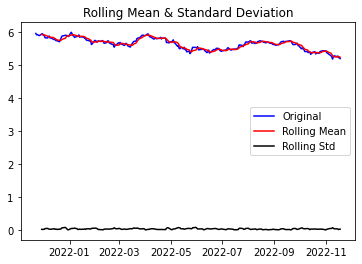

In [37]:
plot_rolling_statistics(ts_tsla_log, window=5) 


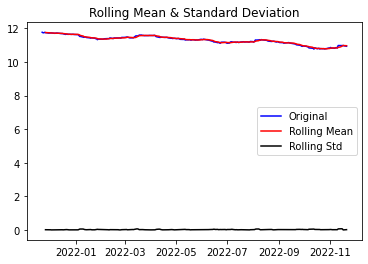

In [38]:
plot_rolling_statistics(ts_kakao_log, window=5) 


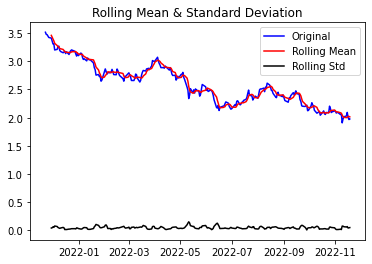

In [39]:
plot_rolling_statistics(ts_QS_log, window=5) 


분명히 로그를 취했는데..값이 이상합니다 ㅠㅠ  
매우 불안정합니다

#### 정량적 ADF test

In [40]:
augmented_dickey_fuller_test(ts_tsla_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.339055
p-value                          0.611121
#Lags Used                       9.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


In [41]:
augmented_dickey_fuller_test(ts_kakao_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.245395
p-value                          0.653769
#Lags Used                       3.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


In [42]:
augmented_dickey_fuller_test(ts_QS_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.929795
p-value                          0.318177
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


세 종목 모두가 모두 귀무가설을 기각할 수 없습니다  
시계열을 가공하여 시계열 예측을 사용할 수 있을지 탐색합니다  
  
#### 시계열 분해  
Trend, Seasonality 추출  

In [43]:
decomposition_tsla = seasonal_decompose(ts_tsla_log, model='additive', period = 5) 
decomposition_kakao = seasonal_decompose(ts_kakao_log, model='additive', period = 5) 
decomposition_QS = seasonal_decompose(ts_QS_log, model='additive', period = 5) 

trend_tsla = decomposition_tsla.trend
seasonal_tsla = decomposition_tsla.seasonal
residual_tsla = decomposition_tsla.resid

trend_kakao = decomposition_kakao.trend
seasonal_kakao = decomposition_kakao.seasonal
residual_kakao = decomposition_kakao.resid

trend_QS = decomposition_QS.trend
seasonal_QS = decomposition_QS.seasonal
residual_QS = decomposition_QS.resid

#모델 additive = trend, seasonal, residual이 더해져있다고 가정할 때 쓰는 파라메터
#https://dsbook.tistory.com/254

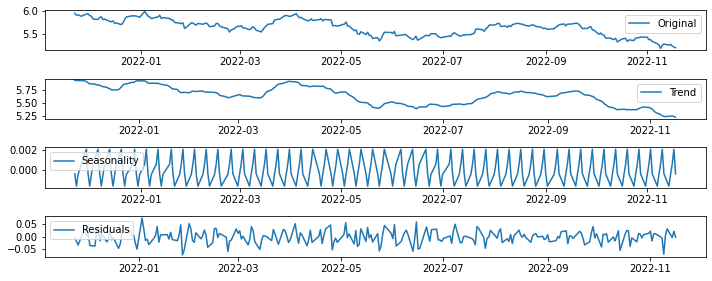

In [44]:
#하나씩 확인합니다 테슬라부터

plt.figure(figsize=(10,4))
plt.subplot(411)
plt.plot(ts_tsla_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_tsla, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_tsla,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_tsla, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

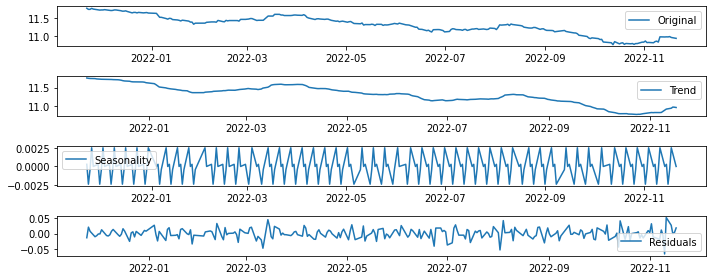

In [45]:
# 카카오
plt.figure(figsize=(10,4))
plt.subplot(411)
plt.plot(ts_kakao_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_kakao, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_kakao,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_kakao, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

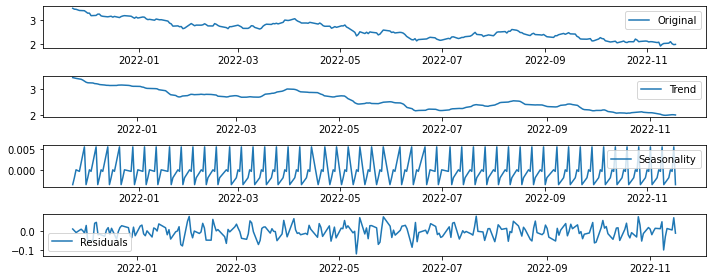

In [46]:

plt.figure(figsize=(10,4))
plt.subplot(411)
plt.plot(ts_QS_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_QS, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_QS,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_QS, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

세 그래프가 모두 비슷한 양상을 보이는 가운데  
레지듀얼의 들쑥날쑥함도 닮아보입니다  

#### 정량적 분석 

In [47]:

residual_tsla.dropna(inplace=True)
augmented_dickey_fuller_test(residual_tsla)

Results of Dickey-Fuller Test:
Test Statistic                -8.506810e+00
p-value                        1.196751e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


In [48]:
residual_kakao.dropna(inplace=True)
augmented_dickey_fuller_test(residual_kakao)

Results of Dickey-Fuller Test:
Test Statistic                -8.250355e+00
p-value                        5.411903e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


In [49]:
residual_QS.dropna(inplace=True)
augmented_dickey_fuller_test(residual_QS)       

Results of Dickey-Fuller Test:
Test Statistic                -8.552773e+00
p-value                        9.128104e-14
#Lags Used                     9.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


세 종목 모두 p-value가 매우 작아 안정성을 확보했습니다  
시계열 예측이 가능하다 간주하고, 모델 생성을 준비합니다

#### ARIMA 모수 탐색  
p : 자기회귀 모형(AR)의 시차  
d : 차분 누적(I) 횟수  
q : 이동평균 모형(MA)의 시차  

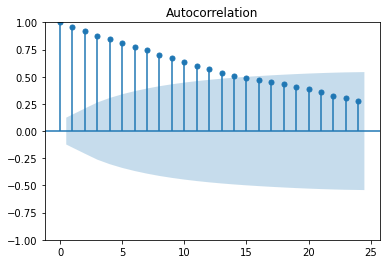

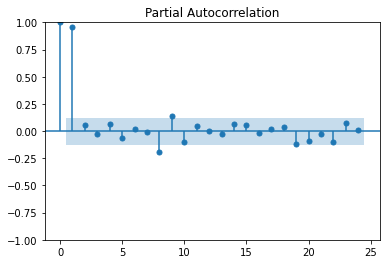

In [50]:

plot_acf(ts_tsla_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_tsla_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

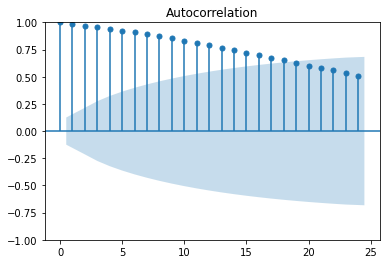

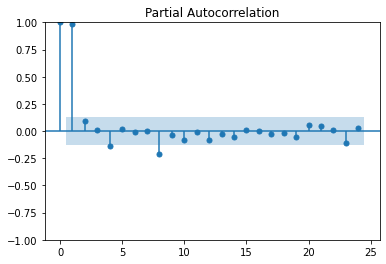

In [51]:
plot_acf(ts_kakao_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_kakao_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

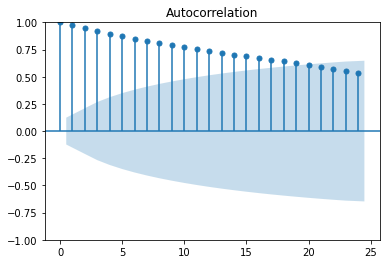

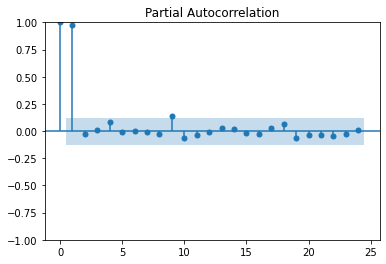

In [52]:
plot_acf(ts_QS_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_QS_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

다르지만 닮은꼴  
  
PACF 그래프에서, 테슬라와 카카오는 3번째부터(2번째 이후), QS (어머니의 투자ㅠㅠ)는 2번째부터(1번째 이후) 0에 가까워지고 있습니다  
또한 세 그래프가 모두 시작점부터 지속적으로 감소하므로  
  
테슬라 카카오 퀀텀 순으로  
p 2 2 1  
q 0 0 0  
  
을 사용하도록 합니다  
  
  
이젠 각 차분을 구해볼 차례입니다

Results of Dickey-Fuller Test:
Test Statistic                  -4.751209
p-value                          0.000067
#Lags Used                       9.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


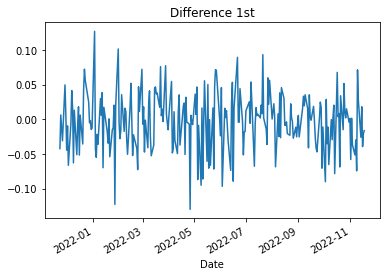

In [53]:
diff_tsla_1 = ts_tsla_log.diff(periods=1).iloc[1:]
diff_tsla_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_tsla_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.142728e+00
p-value                        1.017890e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


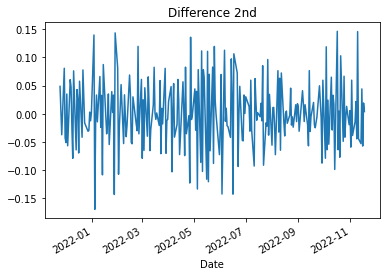

In [54]:
diff_tsla_2 = diff_tsla_1.diff(periods=1).iloc[1:]
diff_tsla_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_tsla_2)

2차 차분 그래프가 더 촘촘하지만, 값의 범위는 1차가 더 작아 보입니다  
테슬라는 d = 1를 사용해봅니다  
  
이제 카카오 데이터를 차분해봅니다  

Results of Dickey-Fuller Test:
Test Statistic                -7.542159e+00
p-value                        3.355900e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


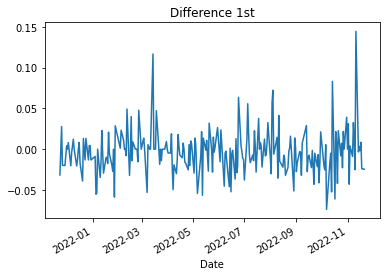

In [55]:
diff_kakao_1 = ts_kakao_log.diff(periods=1).iloc[1:]
diff_kakao_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_kakao_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.907049e+00
p-value                        4.040430e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


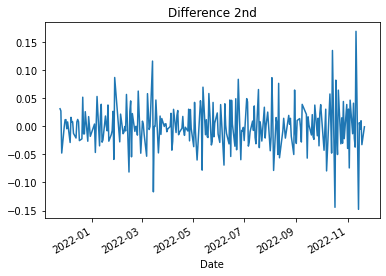

In [56]:
diff_kakao_2 = diff_kakao_1.diff(periods=1).iloc[1:]
diff_kakao_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_kakao_2)

카카오는 2차 그래프의 상승하락이 중앙에 정렬되어 있어 더 안정적으로 보입니다  
카카오는 d = 2를 사용합니다

Results of Dickey-Fuller Test:
Test Statistic                -1.499338e+01
p-value                        1.116838e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


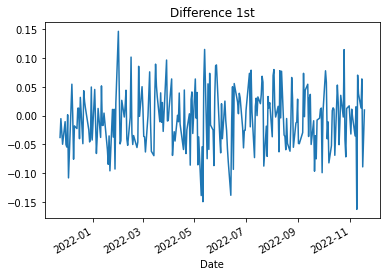

In [57]:
diff_QS_1 = ts_QS_log.diff(periods=1).iloc[1:]
diff_QS_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_QS_1)

Results of Dickey-Fuller Test:
Test Statistic                -9.179548e+00
p-value                        2.271435e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


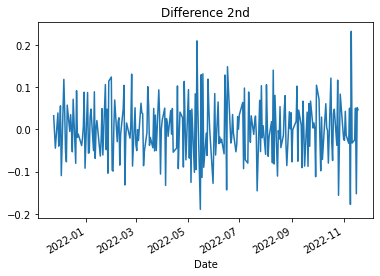

In [58]:
diff_QS_2 = diff_QS_1.diff(periods=1).iloc[1:]
diff_QS_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_QS_2)

퀀텀스케이프의 p-value가 1차 차분이 훨씬 낮습니다  
퀀텀스케이프는 d=1을 사용합니다

(p, d, q)  
테슬라 (2, 1, 0)  
카카오 (2, 2, 0)  
퀀텀스케이프 (1, 1, 0)  

## ARIMA 모델 학습  
트레인 : 테스트셋 9:1 로 시계열 데이터를 사용합니다

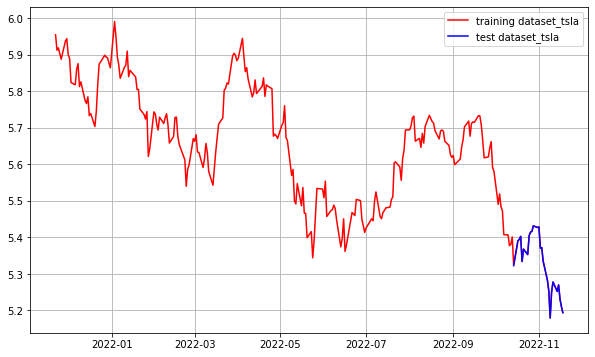

In [59]:
#학습데이터 분리

train_data_tsla, test_data_tsla = ts_tsla_log[:int(len(ts_tsla_log)*0.9)], ts_tsla_log[int(len(ts_tsla_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_tsla_log, c='r', label='training dataset_tsla') 
plt.plot(test_data_tsla, c='b', label='test dataset_tsla')
plt.legend()

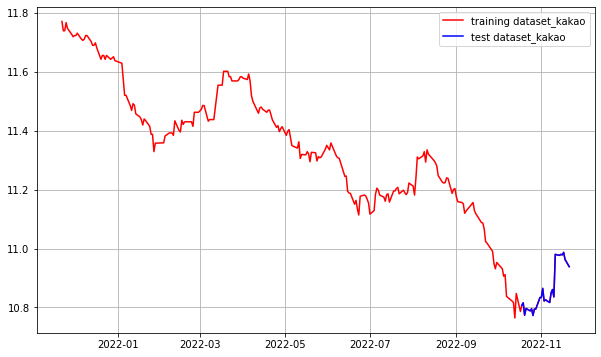

In [60]:
train_data_kakao, test_data_kakao = ts_kakao_log[:int(len(ts_kakao_log)*0.9)], ts_kakao_log[int(len(ts_kakao_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_kakao_log, c='r', label='training dataset_kakao')
plt.plot(test_data_kakao, c='b', label='test dataset_kakao')
plt.legend()

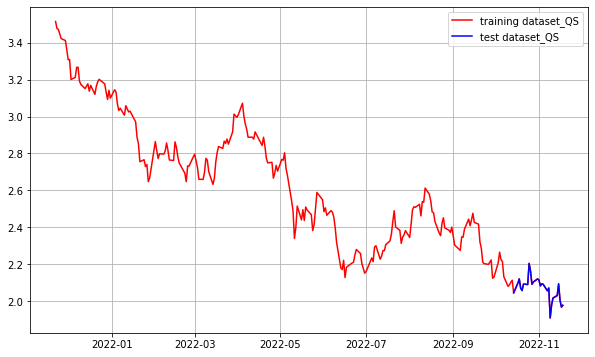

In [61]:
train_data_QS, test_data_QS = ts_QS_log[:int(len(ts_QS_log)*0.9)], ts_QS_log[int(len(ts_QS_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_QS_log, c='r', label='training dataset_QS')
plt.plot(test_data_QS, c='b', label='test dataset_QS')
plt.legend()

In [62]:
#데이터셋을 확인

print("테슬라")
print(ts_tsla_log[:2])
print(train_data_tsla.shape)
print(test_data_tsla.shape)

print("카카오")
print(ts_kakao_log[:2])
print(train_data_kakao.shape)
print(test_data_kakao.shape)

print("퀀텀스케이프 ㅠㅠ")
print(ts_QS_log[:2])
print(train_data_QS.shape)
print(test_data_QS.shape)

테슬라
Date
2021-11-22    5.954861
2021-11-23    5.912629
Name: Close, dtype: float64
(225,)
(26,)
카카오
Date
2021-11-22    11.771011
2021-11-23    11.739388
Name: Close, dtype: float64
(220,)
(25,)
퀀텀스케이프 ㅠㅠ
Date
2021-11-22    3.515121
2021-11-23    3.477232
Name: Close, dtype: float64
(225,)
(26,)


In [63]:
test_data_QS

Date
2022-10-14    2.043814
2022-10-17    2.096790
2022-10-18    2.119863
2022-10-19    2.069391
2022-10-20    2.056685
2022-10-21    2.091864
2022-10-24    2.089392
2022-10-25    2.203869
2022-10-26    2.162173
2022-10-27    2.090629
2022-10-28    2.102914
2022-10-31    2.119863
2022-11-01    2.113843
2022-11-02    2.081938
2022-11-03    2.093098
2022-11-04    2.090629
2022-11-07    2.055405
2022-11-08    2.070653
2022-11-09    1.908060
2022-11-10    1.978239
2022-11-11    2.016235
2022-11-14    2.029463
2022-11-15    2.093098
2022-11-16    2.004179
2022-11-17    1.967112
2022-11-18    1.976855
Name: Close, dtype: float64

In [64]:
model_tsla = ARIMA(train_data_tsla, order=(2, 1, 0))
fitted_m_tsla = model_tsla.fit()

print(fitted_m_tsla.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 398.661
Date:                Mon, 21 Nov 2022   AIC                           -791.323
Time:                        15:46:18   BIC                           -781.088
Sample:                             0   HQIC                          -787.191
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0504      0.087     -0.582      0.560      -0.220       0.119
ar.L2          0.0199      0.056      0.355      0.723      -0.090       0.130
sigma2         0.0017      0.000     11.798      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [65]:
model_kakao = ARIMA(train_data_kakao, order=(2, 2, 0))
fitted_m_kakao = model_kakao.fit()

print(fitted_m_kakao.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 475.572
Date:                Mon, 21 Nov 2022   AIC                           -945.145
Time:                        15:46:18   BIC                           -934.991
Sample:                             0   HQIC                          -941.044
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7891      0.050    -15.635      0.000      -0.888      -0.690
ar.L2         -0.5228      0.058     -8.955      0.000      -0.637      -0.408
sigma2         0.0007   5.27e-05     14.100      0.0

In [66]:
model_QS = ARIMA(train_data_QS, order=(1, 1, 0))
fitted_m_QS = model_QS.fit()

print(fitted_m_QS.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 348.427
Date:                Mon, 21 Nov 2022   AIC                           -692.853
Time:                        15:46:18   BIC                           -686.030
Sample:                             0   HQIC                          -690.099
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1036      0.071      1.460      0.144      -0.035       0.243
sigma2         0.0026      0.000      9.552      0.000       0.002       0.003
Ljung-Box (L1) (Q):                   0.03   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


#### 예측과 에러계산  

세계의 연인, 테슬라

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


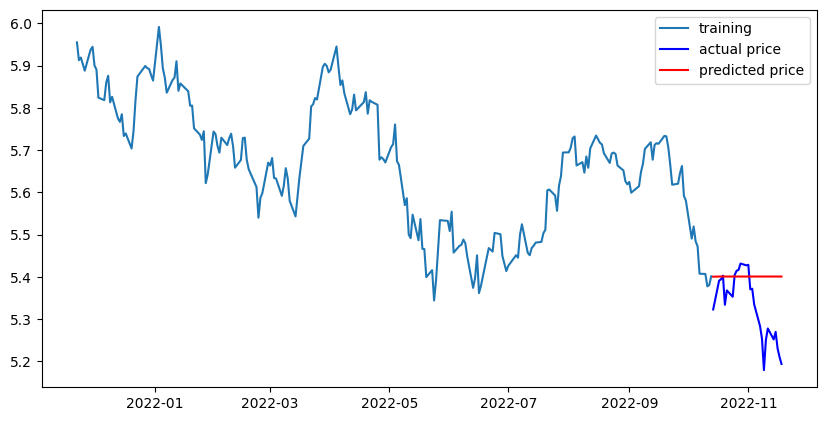

In [67]:
fc_tsla = fitted_m_tsla.forecast(len(test_data_tsla), alpha=0.05)  # 95% conf
fc_tsla = np.array(fc_tsla)

fc_series_tsla = pd.Series(fc_tsla, index=test_data_tsla.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_tsla, label='training')
plt.plot(test_data_tsla, c='b', label='actual price')
plt.plot(fc_series_tsla, c='r',label='predicted price')
plt.legend()
plt.show()

값이 에러가 난건가 두렵습니다  
일단 예측값을 확인합니다

In [68]:
fc_tsla

array([5.40045494, 5.40090897, 5.40086702, 5.40087815, 5.40087676,
       5.40087705, 5.40087701, 5.40087702, 5.40087702, 5.40087702,
       5.40087702, 5.40087702, 5.40087702, 5.40087702, 5.40087702,
       5.40087702, 5.40087702, 5.40087702, 5.40087702, 5.40087702,
       5.40087702, 5.40087702, 5.40087702, 5.40087702, 5.40087702,
       5.40087702])

약간의 변동이 초반 프레딕션값에 관찰이 되긴합니다..  
    
prediction 과정에서 value warning이 있기 때문에, 이 부분 또한 확인해보고자 합니다  
test data의 인덱스에 이상이 있다는 이야기 같아서, 확인해보겠습니다  

In [69]:
test_data_tsla

Date
2022-10-14    5.322961
2022-10-17    5.390669
2022-10-18    5.394491
2022-10-19    5.402858
2022-10-20    5.334071
2022-10-21    5.368030
2022-10-24    5.353042
2022-10-25    5.404567
2022-10-26    5.414499
2022-10-27    5.416500
2022-10-28    5.431624
2022-10-31    5.427326
2022-11-01    5.428556
2022-11-02    5.370545
2022-11-03    5.372079
2022-11-04    5.334987
2022-11-07    5.283610
2022-11-08    5.253843
2022-11-09    5.179478
2022-11-10    5.250806
2022-11-11    5.277962
2022-11-14    5.252012
2022-11-15    5.270021
2022-11-16    5.230681
2022-11-17    5.210415
2022-11-18    5.194012
Name: Close, dtype: float64

이상이 있는지 잘 모르겠습니다..  
아마 첫 인덱스가 주기 5인 연속적인 시계열이 아닌것 같아서 에러가 나는것이 아닐까 예상합니다  
  
프레딕션의 오차들을 확인해봅니다  

In [70]:
mse_tsla = mean_squared_error(np.exp(test_data_tsla), np.exp(fc_tsla))
print('MSE: ', mse_tsla)

mae_tsla = mean_absolute_error(np.exp(test_data_tsla), np.exp(fc_tsla))
print('MAE: ', mae_tsla)

rmse_tsla = math.sqrt(mean_squared_error(np.exp(test_data_tsla), np.exp(fc_tsla)))
print('RMSE: ', rmse_tsla)

mape_tsla = np.mean(np.abs(np.exp(fc_tsla) - np.exp(test_data_tsla))/np.abs(np.exp(test_data_tsla)))
print('MAPE: {:.2f}%'.format(mape_tsla*100))

MSE:  469.6241749249548
MAE:  16.67766061226409
RMSE:  21.670813896228143
MAPE: 8.63%


루브릭 달성조건에는 맞고, MSA MAE RMSE 또한 LMS에서 진행했던 값보다는 현저히 작습니다   

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


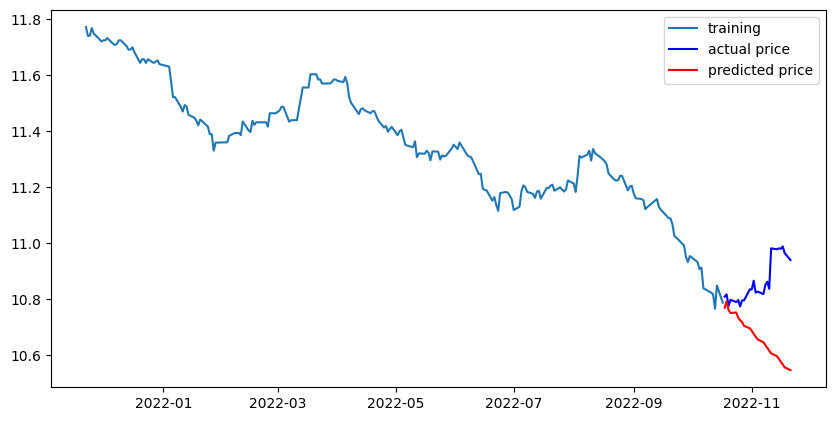

In [71]:
fc_kakao = fitted_m_kakao.forecast(len(test_data_kakao), alpha=0.05)  # 95% conf
fc_kakao = np.array(fc_kakao)

fc_series_kakao = pd.Series(fc_kakao, index=test_data_kakao.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_kakao, label='training')
plt.plot(test_data_kakao, c='b', label='actual price')
plt.plot(fc_series_kakao, c='r',label='predicted price')
plt.legend()
plt.show()

실제값에 비해, 지속적인 하락을 예측하고 있습니다  
공교롭게도 test data 직전까지 실제 데이터 또한 하락중이었기에, 제가 머신이어도 이렇게 예측할 것 같긴 합니다..  

In [72]:
mse_kakao = mean_squared_error(np.exp(test_data_kakao), np.exp(fc_kakao))
print('MSE: ', mse_kakao)

mae_kakao = mean_absolute_error(np.exp(test_data_kakao), np.exp(fc_kakao))
print('MAE: ', mae_kakao)

rmse_kakao = math.sqrt(mean_squared_error(np.exp(test_data_kakao), np.exp(fc_kakao)))
print('RMSE: ', rmse_kakao)

mape_kakao = np.mean(np.abs(np.exp(fc_kakao) - np.exp(test_data_kakao))/np.abs(np.exp(test_data_kakao)))
print('MAPE: {:.2f}%'.format(mape_kakao*100))

MSE:  131248853.998405
MAE:  9248.027252936601
RMSE:  11456.389221670368
MAPE: 16.91%


MAPE 15 초과

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


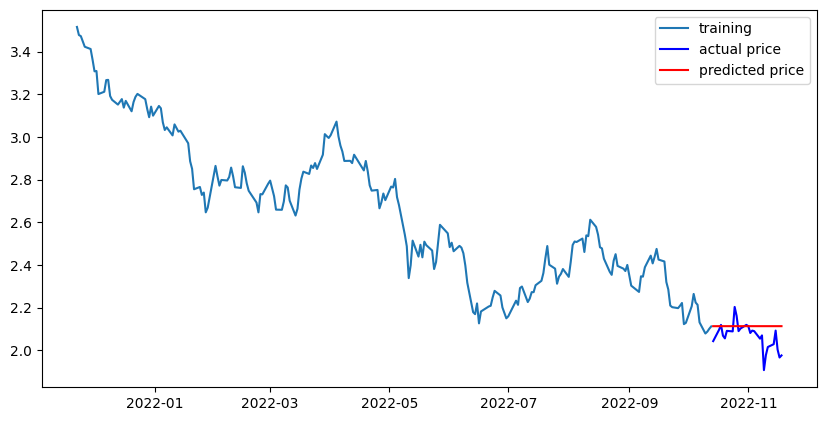

In [73]:
fc_QS = fitted_m_QS.forecast(len(test_data_QS), alpha=0.05)  # 95% conf
fc_QS = np.array(fc_QS)

fc_series_QS = pd.Series(fc_QS, index=test_data_QS.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_QS, label='training')
plt.plot(test_data_QS, c='b', label='actual price')
plt.plot(fc_series_QS, c='r',label='predicted price')
plt.legend()
plt.show()

In [76]:
mse_QS = mean_squared_error(np.exp(test_data_QS), np.exp(fc_QS))
print('MSE: ', mse_QS)

mae_QS = mean_absolute_error(np.exp(test_data_QS), np.exp(fc_QS))
print('MAE: ', mae_QS)

rmse_QS = math.sqrt(mean_squared_error(np.exp(test_data_QS), np.exp(fc_QS)))
print('RMSE: ', rmse_QS)

mape_QS = np.mean(np.abs(np.exp(fc_QS) - np.exp(test_data_QS))/np.abs(np.exp(test_data_QS)))
print('MAPE: {:.2f}%'.format(mape_QS*100))

MSE:  0.37465872950243706
MAE:  0.4679706788339753
RMSE:  0.6120937260766827
MAPE: 6.19%


역시 MAPE는 낮게 나왔습니다만, 테슬라와 마찬가지로 그래프가 평탄하게 나왔습니다

In [75]:
fc_QS

array([2.11376841, 2.11388591, 2.11389809, 2.11389935, 2.11389948,
       2.11389949, 2.1138995 , 2.1138995 , 2.1138995 , 2.1138995 ,
       2.1138995 , 2.1138995 , 2.1138995 , 2.1138995 , 2.1138995 ,
       2.1138995 , 2.1138995 , 2.1138995 , 2.1138995 , 2.1138995 ,
       2.1138995 , 2.1138995 , 2.1138995 , 2.1138995 , 2.1138995 ,
       2.1138995 ])

테슬라와 마찬가지로, 예측값 등락이 매우 작았으며 초반 이후 수렴하게 되었습니다  

다시 pdq 값을 조정해봅니다

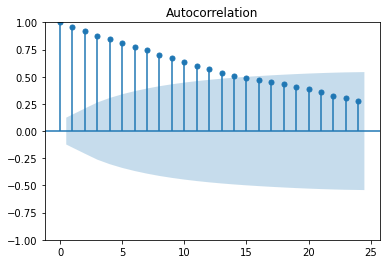

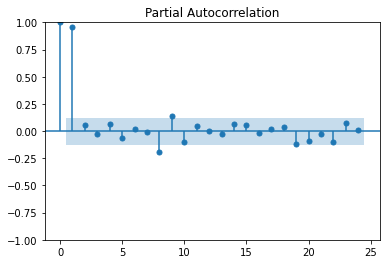

In [77]:

plot_acf(ts_tsla_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_tsla_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

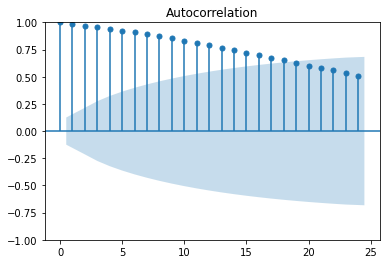

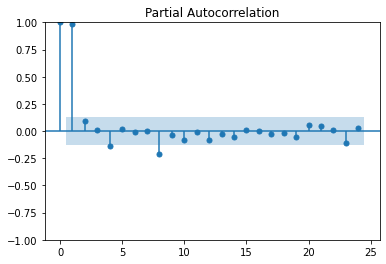

In [78]:
plot_acf(ts_kakao_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_kakao_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

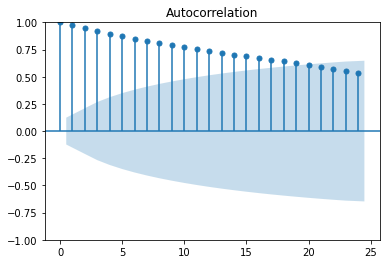

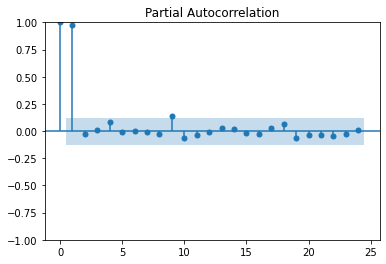

In [79]:
plot_acf(ts_QS_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_QS_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [81]:
model_kakao = ARIMA(train_data_kakao, order=(4, 1, 0))
fitted_m_kakao = model_kakao.fit()

print(fitted_m_kakao.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 499.910
Date:                Mon, 21 Nov 2022   AIC                           -989.820
Time:                        16:37:21   BIC                           -972.875
Sample:                             0   HQIC                          -982.976
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0318      0.067     -0.475      0.634      -0.163       0.099
ar.L2         -0.0011      0.083     -0.013      0.989      -0.164       0.161
ar.L3          0.2504      0.074      3.379      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


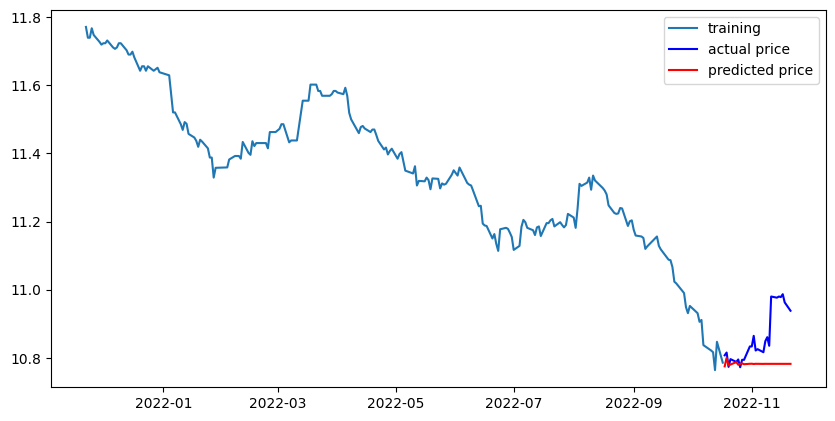

In [84]:
fc_kakao = fitted_m_kakao.forecast(len(test_data_kakao), alpha=0.05)  # 95% conf
fc_kakao = np.array(fc_kakao)

fc_series_kakao = pd.Series(fc_kakao, index=test_data_kakao.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_kakao, label='training')
plt.plot(test_data_kakao, c='b', label='actual price')
plt.plot(fc_series_kakao, c='r',label='predicted price')
plt.legend()
plt.show()

테슬라조차 그래프가 이상하게 나온다  
이쯤되면 데이터 분리과정에서 문제가 있었다고 판단이 되고
변화치가 충분하지 않다는 관찰에서 떠오른 아이디어는  
Trends , Seasonality, Residual에서 분해 파라메터를 설정하였다는것,
그래서 다른 파라메터인 mul 로 다시 진행해보기로 합니다  
  
시계열 데이터의 decomposition 시  
Trend T/ Seasonality S/ residual R에 대해  
주식가격의 시계열 Ts = T+S+R 로 가정하고 lms와 다르게 model의 파라메터 값을 additive로 주어 진행하였지만,  
Ts = T*S*R, multiplicative 파라메터로 바꾸어 학습

In [ ]:
decomposition_tsla = seasonal_decompose(ts_tsla_log, model='multiplicative', period = 5) 
decomposition_kakao = seasonal_decompose(ts_kakao_log, model='multiplicative', period = 5) 
decomposition_QS = seasonal_decompose(ts_QS_log, model='multiplicative', period = 5) 

trend_tsla = decomposition_tsla.trend
seasonal_tsla = decomposition_tsla.seasonal
residual_tsla = decomposition_tsla.resid

trend_kakao = decomposition_kakao.trend
seasonal_kakao = decomposition_kakao.seasonal
residual_kakao = decomposition_kakao.resid

trend_QS = decomposition_QS.trend
seasonal_QS = decomposition_QS.seasonal
residual_QS = decomposition_QS.resid

#모델 additive = trend, seasonal, residual이 더해져있다고 가정할 때 쓰는 파라메터
#https://dsbook.tistory.com/254

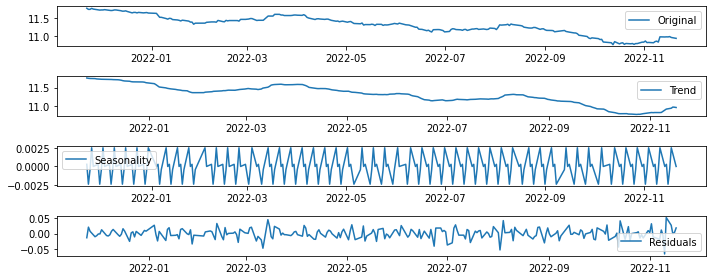

In [87]:
# 카카오
plt.figure(figsize=(10,4))
plt.subplot(411)
plt.plot(ts_kakao_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_kakao, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_kakao,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_kakao, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

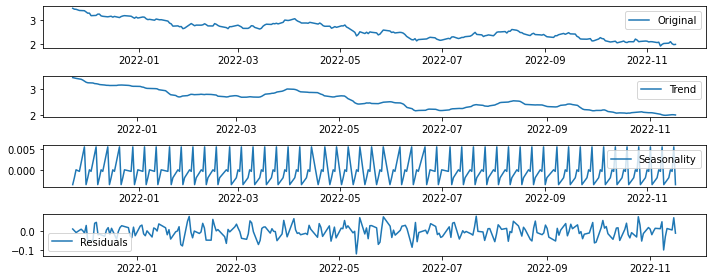

In [88]:

plt.figure(figsize=(10,4))
plt.subplot(411)
plt.plot(ts_QS_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_QS, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_QS,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_QS, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 정량분석  

## 회고  
  
루브릭의 조건인 MAPE 15% 이하에 대해, 1%대로 낮은 오차율을 달성하긴 했습니다만..  
시간이 충분해, 다양한 parameter를 사용해서 테스트 했으면 좋았을거라는 아쉬움이 남습니다  
  
특히, 
  
http://insightcampus.co.kr:9090/insightcommunity/?mod=document&uid=12855  
에 소개된, 이 코드에서 가정한 5일 주기의 Ts 말고도 월주기, 연주기를 계산하여 학습을 진행해보지 못했던 점이 아쉬움으로 남습니다  
  
또한, 구글에 arima 모델의 정확한 용법을 찾던 중 지나치듯 본 grid search로 최적의 값을 찾는 방법도 추후에 실습해보고 싶습니다  
꼭 arima 모델이 아니더라도, 다음 prediction task에는 grid search를 사용해보고자 합니다  

마지막으로, 어머니가 주식을 많이 잃으셔서 가계에 보탬이 되고 싶었습니다..  
꼭 언젠가 좋은 예측모델을 만들어낼 것입니다  
  
# 퀀텀스케이프 흥해라  